# IMPORTS

In [63]:
import os
from collections import defaultdict
from glob import glob
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm

In [2]:
DATA_ROOT = Path("../data/01_raw/COVID-19_Radiography_Dataset")

# ANALYSES DES METADONNEES

In [3]:
metadata = pd.concat(
    [pd.read_excel(file) for file in glob(os.path.join(DATA_ROOT, "*.metadata.xlsx"))]
)
metadata.columns = ["file_name", "format", "size", "url"]

In [4]:
metadata.head()

,file_name,format,size,url
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [5]:
metadata["health_status"] = metadata.file_name.apply(lambda x: x.split("-")[0])
metadata["is_healthy"] = metadata.file_name.apply(
    lambda x: "Sain" if "normal" in x.lower() else "Malade"
)

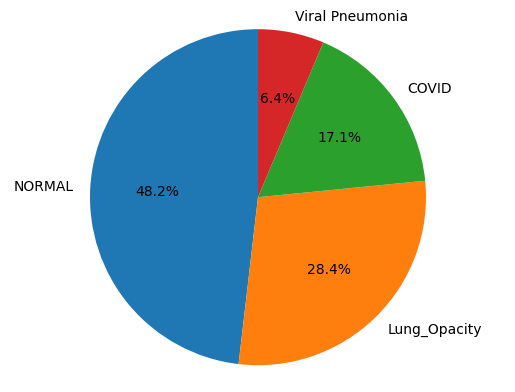

In [6]:
hs_counts = metadata.health_status.value_counts()

plt.pie(hs_counts.values, labels=hs_counts.index, autopct="%1.1f%%", startangle=90)
plt.axis("equal")  # ensures the pie is a circle
plt.show()

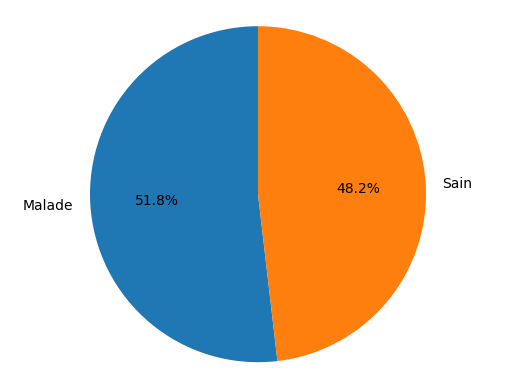

In [7]:
ih_counts = metadata.is_healthy.value_counts()

plt.pie(ih_counts.values, labels=ih_counts.index, autopct="%1.1f%%", startangle=90)
plt.axis("equal")  # ensures the pie is a circle
plt.show()

# ANALYSE TEXTURAL DES IMAGES

In [8]:
REPS = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [9]:
images = defaultdict()

In [48]:
for rep in REPS:
    images[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(DATA_ROOT / rep / "images/*.png"))
    ]

In [67]:
basic_ft_list = ["mean", "variance", "std", "entropy"]
advanced_ft_list = [
    "contrast",
    "dissimilarity",
    "homogeneity",
    "ASM",
    "energy",
    "correlation",
]

In [68]:
IMG_SIZE = 299
DMAX = int(IMG_SIZE / 10)
ANGLES = (np.pi / 4) * np.arange(0, 4)  # angles en radian de 0 à pi

In [78]:
def compute_haralick(images: defaultdict, ft_list: list, dmax: int, angles: list):
    distances = range(dmax)
    features = defaultdict(lambda: defaultdict(lambda: np.empty((dmax, 0))))

    def process_image(img, ft_list, distances, angles):
        glcm = graycomatrix(
            img, distances=distances, angles=angles, symmetric=True, normed=True
        )
        result = {}
        for ft in ft_list:
            props = graycoprops(glcm, prop=ft)
            result[ft] = props
        return result

    for rep, pool in tqdm(images.items()):
        results = Parallel(n_jobs=-1, verbose=1)(
            delayed(process_image)(img, ft_list, distances, angles) for img in pool
        )

        for ft in ft_list:
            for r in results:
                features[ft][rep] = np.concat([features[ft][rep], r[ft]], axis=1)
    return features

In [94]:
# basic_features = compute_haralick(images, basic_ft_list, DMAX, ANGLES)
basic_features = defaultdict(lambda: defaultdict(lambda: np.empty((0))))

In [95]:
# for rep in images.keys():
#     for ft in basic_ft_list:
#         np.save(file=f"../data/00_dumps/haralick_basic_features_{ft}_{rep}.npy", arr=basic_features[ft][rep], allow_pickle=False)

In [96]:
for rep in images.keys():
    for ft in basic_ft_list:
        basic_features[ft][rep] = np.load(
            f"../data/00_dumps/haralick_basic_features_{ft}_{rep}.npy"
        )

In [ ]:
np.mean(basic_features["mean"]["covid"][:, ::4], axis=1)

(29,)

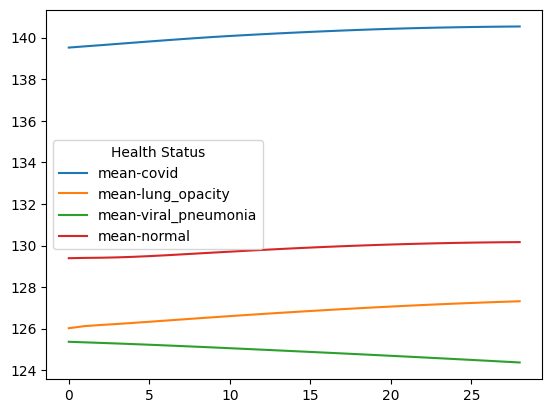

In [123]:
for rep in images.keys():
    plt.plot(np.mean(basic_features["mean"][rep][:, 2::4], axis=1), label=f"mean-{rep}")

plt.legend(title="Health Status")

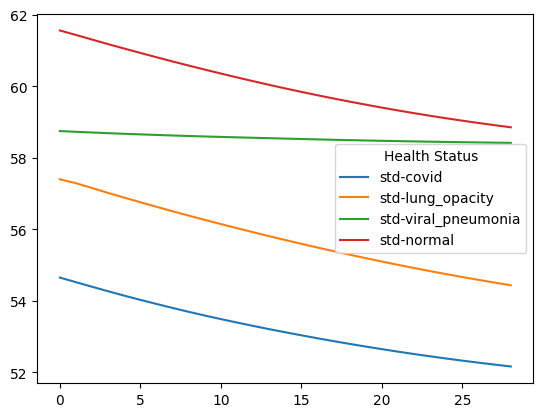

In [124]:
for rep in images.keys():
    plt.plot(np.mean(basic_features["std"][rep][:, 2::4], axis=1), label=f"std-{rep}")

plt.legend(title="Health Status")

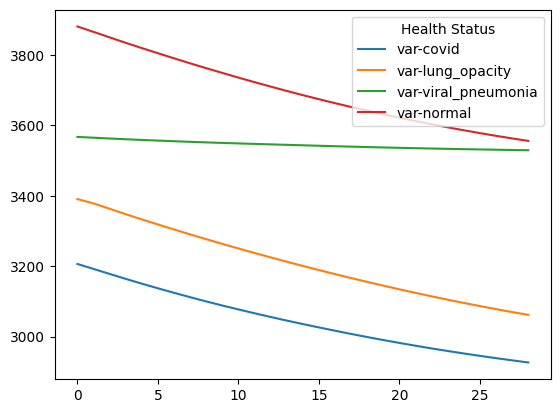

In [125]:
for rep in images.keys():
    plt.plot(
        np.mean(basic_features["variance"][rep][:, 2::4], axis=1), label=f"var-{rep}"
    )

plt.legend(title="Health Status")

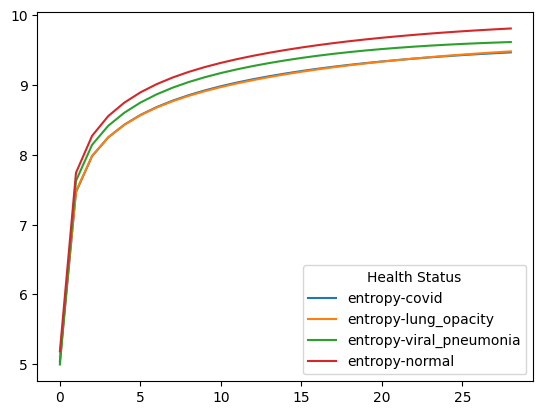

In [132]:
for rep in images.keys():
    plt.plot(
        np.mean(basic_features["entropy"][rep][:, 0::4], axis=1), label=f"entropy-{rep}"
    )

plt.legend(title="Health Status")